# Tutorial: Actor Critic Implementation

In [1]:
#Import required libraries

import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
#Set constants for training
seed = 543
log_interval = 10
gamma = 0.99

env = gym.make('CartPole-v1')
env.reset(seed=seed)
torch.manual_seed(seed)

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
env = gym.make('CartPole-v1')
env.reset(seed=seed)
torch.manual_seed(seed)


SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


class Policy_shared(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy_shared, self).__init__()
        self.affine1 = nn.Linear(4, 128)

        # actor's layer
        self.action_head = nn.Linear(128, 2)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values


In [16]:

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (left or right)
    return action.item()


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


def train():
    running_reward = 10
    reward_history = []
    # run infinitely many episodes
    for i_episode in range(2000):

        # reset environment and episode reward
        state = env.reset()
        ep_reward = 0

        # for each episode, only run 9999 steps so that we don't
        # infinite loop while learning
        for t in range(1, 10000):

            # select action from policy
            action = select_action(state)

            # take the action
            state, reward, done, _ = env.step(action)

            model.rewards.append(reward)
            ep_reward += reward

            if done:
                break

        # update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        # perform backprop
        finish_episode()

        # log results
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
            reward_history.append(ep_reward)
        # check if we have "solved" the cart pole problem
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break
    return reward_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
model = Policy_shared()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()
shared_reward_history = train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 0	Last reward: 17.00	Average reward: 10.35
Episode 10	Last reward: 17.00	Average reward: 16.08
Episode 20	Last reward: 21.00	Average reward: 21.79
Episode 30	Last reward: 53.00	Average reward: 25.65
Episode 40	Last reward: 90.00	Average reward: 30.32
Episode 50	Last reward: 189.00	Average reward: 56.90
Episode 60	Last reward: 103.00	Average reward: 70.98
Episode 70	Last reward: 253.00	Average reward: 116.79
Episode 80	Last reward: 230.00	Average reward: 169.81
Episode 90	Last reward: 403.00	Average reward: 224.31
Episode 100	Last reward: 213.00	Average reward: 264.66
Episode 110	Last reward: 500.00	Average reward: 301.10
Episode 120	Last reward: 500.00	Average reward: 380.91
Episode 130	Last reward: 180.00	Average reward: 354.75
Episode 140	Last reward: 135.00	Average reward: 269.28
Episode 150	Last reward: 182.00	Average reward: 220.52
Episode 160	Last reward: 212.00	Average reward: 195.96
Episode 170	Last reward: 500.00	Average reward: 262.26
Episode 180	Last reward: 500.00	A

Text(0.5, 1.0, 'Performance of Shared Network')

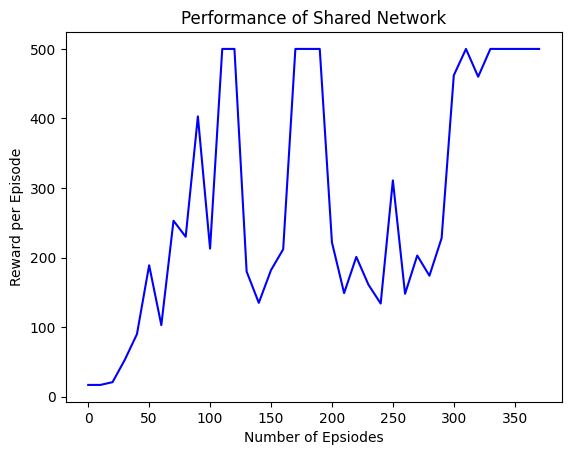

In [31]:
import matplotlib.pyplot as plt
x = np.arange(0,len(shared_reward_history))*10
plt.plot(x,shared_reward_history,color='blue')
plt.xlabel('Number of Epsiodes')
plt.ylabel('Reward per Episode')
plt.title("Performance of Shared Network")

In [30]:
len(shared_reward_history)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


38

# TODO: Write a policy class similar to the above, without using shared features for the actor and critic and compare their performance.

In [19]:

#TODO: Write a policy class similar to the above, without using shared features for the actor and critic and compare their
# performance.

class UnsharedPolicy(nn.Module):
  def __init__(self):
    super(UnsharedPolicy, self).__init__()
    #TODO: Fill in.
    # actor's network
    self.affine1 = nn.Linear(4, 128)
    self.action_head = nn.Linear(128, 2)

    # critic's network
    self.affine2 = nn.Linear(4, 128)
    self.value_head = nn.Linear(128, 1)

    # action & reward buffer
    self.saved_actions = []
    self.rewards = []

  def forward(self, x):
      # TODO: Fill in. For your networks, use the same hidden_size for the layers as the previous policy, that is 128.

      # return values for both actor and critic as a tuple of 2 values:
      # 1. a list with the probability of each action over the action space
      # 2. the value from state s_t

      x_action = F.relu(self.affine1(x))
      # actor: choses action to take from state s_t
      # by returning probability of each action
      action_prob = F.softmax(self.action_head(x_action), dim=-1)

      x_value = F.relu(self.affine2(x))
      # critic: evaluates being in the state s_t
      state_values = self.value_head(x_value)

      # return values for both actor and critic as a tuple of 2 values:
      # 1. a list with the probability of each action over the action space
      # 2. the value from state s_t
      return action_prob, state_values

      #pass

In [20]:
model = UnsharedPolicy()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()
unshared_reward_history = train()

Episode 0	Last reward: 14.00	Average reward: 10.20
Episode 10	Last reward: 21.00	Average reward: 17.50
Episode 20	Last reward: 10.00	Average reward: 19.68
Episode 30	Last reward: 49.00	Average reward: 23.67
Episode 40	Last reward: 33.00	Average reward: 39.48
Episode 50	Last reward: 38.00	Average reward: 43.51
Episode 60	Last reward: 41.00	Average reward: 51.67
Episode 70	Last reward: 270.00	Average reward: 116.44
Episode 80	Last reward: 440.00	Average reward: 190.00
Episode 90	Last reward: 288.00	Average reward: 270.65
Episode 100	Last reward: 500.00	Average reward: 357.04
Episode 110	Last reward: 500.00	Average reward: 412.41
Episode 120	Last reward: 500.00	Average reward: 376.84
Episode 130	Last reward: 500.00	Average reward: 424.12
Episode 140	Last reward: 500.00	Average reward: 430.82
Episode 150	Last reward: 500.00	Average reward: 448.18
Episode 160	Last reward: 444.00	Average reward: 451.58
Episode 170	Last reward: 500.00	Average reward: 471.01
Solved! Running reward is now 475.1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Performance of Unshared Network')

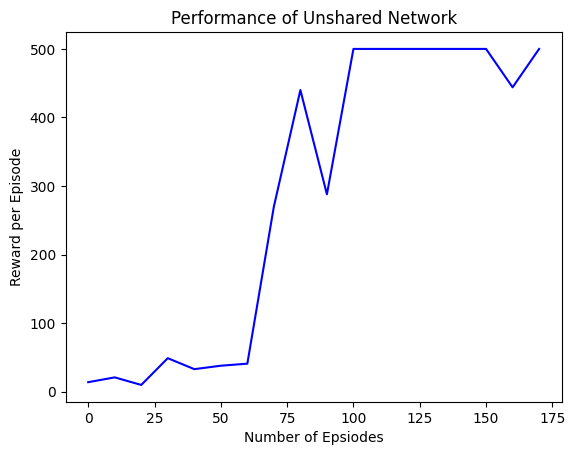

In [32]:
x = np.arange(0,len(unshared_reward_history))*10
plt.plot(x,unshared_reward_history,color='blue')
plt.xlabel('Number of Epsiodes')
plt.ylabel('Reward per Episode')
plt.title("Performance of Unshared Network")

Text(0.5, 1.0, 'Comparing Shared vs Unshared Network')

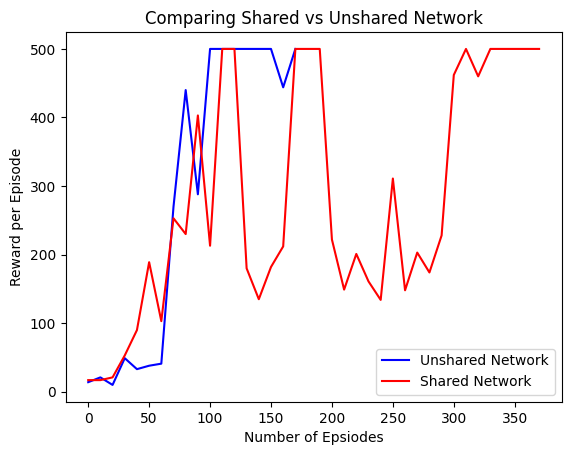

In [33]:
plt.figure()
x = np.arange(0,len(unshared_reward_history))*10
plt.plot(x,unshared_reward_history,color='blue',label='Unshared Network')
x = np.arange(0,len(shared_reward_history))*10
plt.plot(x,shared_reward_history,color='red',label='Shared Network')
plt.legend()
plt.xlabel('Number of Epsiodes')
plt.ylabel('Reward per Episode')
plt.title("Comparing Shared vs Unshared Network")

## **Conclusion:**

1. A learning rate of 0.01 was used for both the shared and the unshared network
2. Shared network takes 370 epsiodes to solve the cartpole environment
3. Whereas the unshared network takes only 170 epsiodes to solve the environment
4. Although the unshared network performs better in this case, than the shared network, the networks are susceptible to random initialisations. On running twise, the same performance does not occur
5. The unshared network is only preferred in cases where different features are required for the action and value network. Since in this environment, no such necessity occurs, and hence, shared network should be enough.